In [1]:
import deepxde as dde
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# def VDP():
#    """Define the ODE of VDP"""
   
# # Call odeint in Scipy to generate numerical exact solutions
# y = odeint(VDP)

# # Sample and generate the training set from the exact solution, including initial point (t0, y0) and endpoint
# t_data=t[0:1.5:0.005]
# y_data=y[0:1.5:0.005]
# geom = dde.geometry.TimeDomain(0.0, 1.5) # Define time domain

# def boundary(t, on_boundary):
#    return on_boundary and dde.utils.isclose(t[0], 0)

# def error_derivative(inputs, outputs, X):
#    return dde.grad.jacobian(outputs, inputs, i=0, j=None)

# ic1 = dde.icbc.IC(geom, lambda x : 1, lambda _, on_initial: on_initial)
# ic2 = dde.icbc.OperatorBC(geom, error_derivative,boundary)

# # Define training set and boundary conditions (including boundary conditions)
# t_y_data = dde.PointSetBC(t_data, y_data)
# data = dde.data.TimePDE(geom, ode, [ic1, ic2, t_y_data],
# num_domain=40, num_boundary=1)

# # num_domain is the number of collocation points
# net = dde.maps.FNN([1] + [32] * 3 + [1]) # Instantiate FNN
# model = dde.Model(data, net)
# model.train(epochs=24000)

Compiling model...
Building feed-forward neural network...
'build' took 0.049011 s


'compile' took 0.467129 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.75e+03, 1.00e+00, 2.86e+00, 3.04e+00]    [1.75e+03, 1.00e+00, 2.86e+00, 3.04e+00]    []  
1000      [5.18e-03, 9.94e-01, 2.54e-04, 1.98e+00]    [5.18e-03, 9.94e-01, 2.54e-04, 1.98e+00]    []  
2000      [4.95e-03, 9.93e-01, 3.20e-04, 1.98e+00]    [4.95e-03, 9.93e-01, 3.20e-04, 1.98e+00]    []  
3000      [4.89e-03, 9.91e-01, 1.81e-04, 1.98e+00]    [4.89e-03, 9.91e-01, 1.81e-04, 1.98e+00]    []  
4000      [5.36e-03, 9.90e-01, 7.12e-05, 1.98e+00]    [5.36e-03, 9.90e-01, 7.12e-05, 1.98e+00]    []  
5000      [6.22e-03, 9.88e-01, 1.96e-05, 1.98e+00]    [6.22e-03, 9.88e-01, 1.96e-05, 1.98e+00]    []  
6000      [7.11e-03, 9.86e-01, 6.74e-06, 1.98e+00]    [7.11e-03, 9.86e-01, 6.74e-06, 1.98e+00]    []  
7000      [8.33e-03, 9.84e-01, 3.83e-0

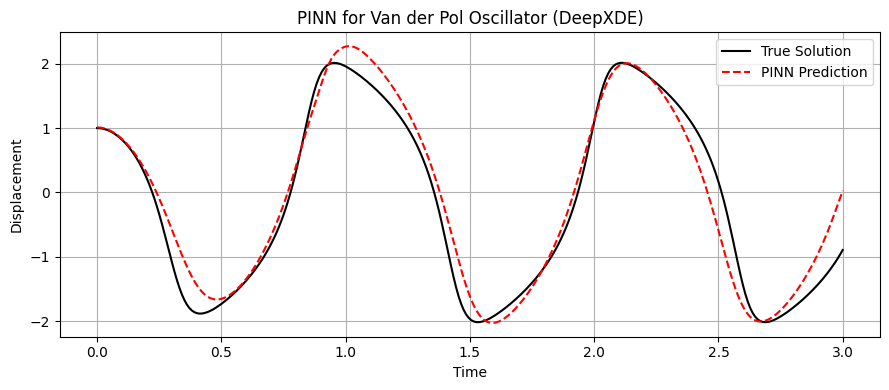

In [3]:
omega=36
# 1. Define the Van der Pol ODE system
def VDP(y, t, mu=8):
    x, dx = y
    d2x = mu * (1 - x**2) * dx - omega*x
    return [dx, d2x]

# 2. Generate reference data using Scipy's odeint
t = np.linspace(0, 3, 300)
y0 = [1.0, 0.0]  # Initial condition: x(0) = 1, dx/dt(0) = 0
y = odeint(VDP, y0, t)

# 3. Prepare training data: only x(t), not dx/dt
t_data = t.reshape(-1, 1)
y_data = y[:, 0:1]  # Only x(t), not dx/dt

# 4. Define PDE residual: f = d2x/dt2 - mu*(1 - x^2)*dx/dt + x = 0
def VDP_pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=0)      # dx/dt
    d2y_tt = dde.grad.hessian(y, x, component=0)  # d2x/dt2
    mu = 4.0
    return d2y_tt - mu * (1 - y**2) * dy_t + omega*y

# 5. Define geometry
geom = dde.geometry.TimeDomain(0.0, 3.0)

# 6. Define initial condition x(0) = 1
ic1 = dde.icbc.IC(geom, lambda x: 1.0, lambda _, on_initial: on_initial)

# 7. Define derivative condition dx/dt(0) = 0 using OperatorBC
def boundary(t, on_boundary):
    return on_boundary and dde.utils.isclose(t[0], 0)

def derivative_operator(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=0)  # dx/dt

ic2 = dde.icbc.OperatorBC(geom, derivative_operator, boundary)

# 8. Data-driven component (optional): include exact sampled solution
t_y_data = dde.PointSetBC(t_data, y_data)

# 9. Build data object
data = dde.data.TimePDE(
    geom, VDP_pde, [ic1, ic2, t_y_data], num_domain=40, num_boundary=1
)

# 10. Define neural network (FNN with 3 hidden layers of 32 neurons)
net = dde.maps.FNN([1] + [32] * 5 + [1], "tanh", "Glorot uniform")

# 11. Build and train the model
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=90000)

# 12. Plot prediction vs true
y_pred = model.predict(t_data)

plt.figure(figsize=(9,4))
plt.plot(t, y[:,0], "k-", label="True Solution")
plt.plot(t, y_pred, "r--", label="PINN Prediction")
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.title("PINN for Van der Pol Oscillator (DeepXDE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()